<a href="https://colab.research.google.com/github/mshilpaa/EVA4/blob/master/Session%2011/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install -U git+https://github.com/albu/albumentations

  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-tvs8zm61
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-tvs8zm61
  Created wheel for albumentations: filename=albumentations-0.4.5-cp36-none-any.whl size=65099 sha256=fda468cebaaa209211df129aa0a9a32f51ee9f8b2208c918b9b2d976b45c7445
  Stored in directory: /tmp/pip-ephem-wheel-cache-l_7hls1o/wheels/45/8b/e4/2837bbcf517d00732b8e394f8646f22b8723ac00993230188b
Successfully built albumentations
  Found existing installation: albumentations 0.4.5
    Uninstalling albumentations-0.4.5:
      Successfully uninstalled albumentations-0.4.5


In [0]:
# mount gdrive and unzip data
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import sys
folder = '/content/gdrive/My Drive/Colab Notebooks/eva_files'
sys.path.append(folder)

In [0]:
%matplotlib inline
import torch
import data_loading
import show_images
import dnn_architecture
import train_and_test
import evaluate
import gradcam
import lr_finder

  pip install torch-lr-finder -v --global-option="amp"


In [0]:
import albumentations as A
import cv2
train_aug = [ 
             A.PadIfNeeded(min_height=36, min_width=36, p=1.0),
              A.RandomCrop(32, 32, always_apply=False, p=1.0),
              A.HorizontalFlip(),
              A.Cutout(num_holes=2, max_h_size=8,max_w_size = 8,p=1,fill_value=0.5*255), 
              A.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)),]

classes, trainloader, testloader = data_loading.load(train_augmentation = train_aug,mode='default_test_aug',gpu_batch_size=512)

Files already downloaded and verified
Files already downloaded and verified
CUDA Available? True


shape: torch.Size([512, 3, 32, 32])
  cat truck truck   cat


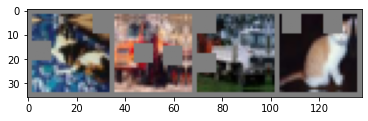

In [0]:
show_images.show_random_images(trainloader, classes)

In [0]:
import matplotlib.pyplot as plt

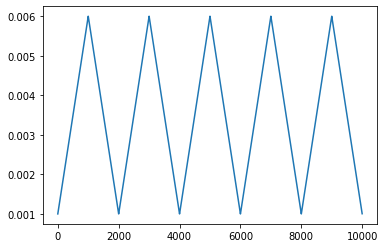

In [0]:
# Sample cyclic lr code :

import matplotlib.pyplot as plt
import numpy as np
def CyclicLR(num_iterations,base_lr,max_lr,step_size):
  l_rate =[]
  for iteration in range(num_iterations):
    cycle = np.floor(1+iteration/(2*step_size))
    x = np.abs(iteration/step_size - 2*cycle + 1)
    lr = base_lr + (max_lr-base_lr)*np.maximum(0, (1-x))
    l_rate.append(lr)
  plt.plot(list(range(num_iterations)),l_rate)

CyclicLR(num_iterations=10000,base_lr=0.001, max_lr=0.006,step_size=1000)

In [0]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = dnn_architecture.New_Resnet().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1,

**Range test for one cycle lr**

In [0]:
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = dnn_architecture.New_Resnet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9,weight_decay=0.0005)

lrs,trainAcc,trainLoss,testAcc,testLoss = train_and_test.one_cycle_lr_range_test(min_lr=0.004,max_lr=0.01,steps=40,initial_model=model,device=device,
                                                                                 trainloader=trainloader,testloader=testloader,criterion=criterion,optimizer=optimizer)


  0%|          | 0/98 [00:00<?, ?it/s]

0 ) LR: 0.004


Loss=1.2437995672225952 Batch_id=97 Accuracy=43.57: 100%|██████████| 98/98 [01:39<00:00,  1.01s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0024, Accuracy: 5710/10000 (57.10%)

1 ) LR: 0.00415


Loss=1.2739702463150024 Batch_id=97 Accuracy=43.17: 100%|██████████| 98/98 [01:39<00:00,  1.01s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0024, Accuracy: 5588/10000 (55.88%)

2 ) LR: 0.0043


Loss=1.1792210340499878 Batch_id=97 Accuracy=45.18: 100%|██████████| 98/98 [01:39<00:00,  1.01s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 5992/10000 (59.92%)

3 ) LR: 0.00445


Loss=1.3460767269134521 Batch_id=97 Accuracy=39.61: 100%|██████████| 98/98 [01:39<00:00,  1.01s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 5049/10000 (50.49%)

4 ) LR: 0.0046


Loss=1.2439419031143188 Batch_id=97 Accuracy=44.97: 100%|██████████| 98/98 [01:39<00:00,  1.02s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0024, Accuracy: 5761/10000 (57.61%)

5 ) LR: 0.00475


Loss=1.3480522632598877 Batch_id=97 Accuracy=43.62: 100%|██████████| 98/98 [01:39<00:00,  1.01s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0026, Accuracy: 5556/10000 (55.56%)

6 ) LR: 0.0049


Loss=1.2232688665390015 Batch_id=97 Accuracy=44.61: 100%|██████████| 98/98 [01:39<00:00,  1.01s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0025, Accuracy: 5618/10000 (56.18%)

7 ) LR: 0.00505


Loss=1.340410828590393 Batch_id=97 Accuracy=38.16: 100%|██████████| 98/98 [01:39<00:00,  1.01s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0025, Accuracy: 5396/10000 (53.96%)

8 ) LR: 0.0052


Loss=1.3113585710525513 Batch_id=97 Accuracy=42.98: 100%|██████████| 98/98 [01:38<00:00,  1.01s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0028, Accuracy: 5045/10000 (50.45%)

9 ) LR: 0.00535


Loss=1.159369945526123 Batch_id=97 Accuracy=42.96: 100%|██████████| 98/98 [01:38<00:00,  1.01s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 5843/10000 (58.43%)

10 ) LR: 0.0055


Loss=1.2824008464813232 Batch_id=97 Accuracy=37.83: 100%|██████████| 98/98 [01:38<00:00,  1.00s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0028, Accuracy: 4984/10000 (49.84%)

11 ) LR: 0.00565


Loss=1.341328740119934 Batch_id=97 Accuracy=38.85: 100%|██████████| 98/98 [01:39<00:00,  1.01s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0025, Accuracy: 5487/10000 (54.87%)

12 ) LR: 0.0058


Loss=1.2182139158248901 Batch_id=97 Accuracy=40.37: 100%|██████████| 98/98 [01:39<00:00,  1.01s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0028, Accuracy: 5113/10000 (51.13%)

13 ) LR: 0.0059499999999999996


Loss=1.2659505605697632 Batch_id=97 Accuracy=42.70: 100%|██████████| 98/98 [01:39<00:00,  1.01s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 5140/10000 (51.40%)

14 ) LR: 0.0060999999999999995


Loss=1.2385807037353516 Batch_id=97 Accuracy=43.60: 100%|██████████| 98/98 [01:39<00:00,  1.01s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0025, Accuracy: 5519/10000 (55.19%)

15 ) LR: 0.0062499999999999995


Loss=1.197652816772461 Batch_id=97 Accuracy=43.82: 100%|██████████| 98/98 [01:39<00:00,  1.01s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 5407/10000 (54.07%)

16 ) LR: 0.0063999999999999994


Loss=1.3972301483154297 Batch_id=97 Accuracy=36.22: 100%|██████████| 98/98 [01:39<00:00,  1.02s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 5103/10000 (51.03%)

17 ) LR: 0.006549999999999999


Loss=1.4784209728240967 Batch_id=97 Accuracy=32.25: 100%|██████████| 98/98 [01:39<00:00,  1.01s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0031, Accuracy: 4493/10000 (44.93%)

18 ) LR: 0.006699999999999999


Loss=1.5231695175170898 Batch_id=97 Accuracy=33.44: 100%|██████████| 98/98 [01:39<00:00,  1.01s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0030, Accuracy: 4532/10000 (45.32%)

19 ) LR: 0.006849999999999999


Loss=1.6475340127944946 Batch_id=97 Accuracy=33.79: 100%|██████████| 98/98 [01:39<00:00,  1.01s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0028, Accuracy: 4897/10000 (48.97%)

20 ) LR: 0.006999999999999999


Loss=1.4276814460754395 Batch_id=97 Accuracy=32.67: 100%|██████████| 98/98 [01:39<00:00,  1.01s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0034, Accuracy: 4068/10000 (40.68%)

21 ) LR: 0.007149999999999999


Loss=1.4665007591247559 Batch_id=97 Accuracy=34.03: 100%|██████████| 98/98 [01:39<00:00,  1.01s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0029, Accuracy: 4882/10000 (48.82%)

22 ) LR: 0.007299999999999999


Loss=1.231762409210205 Batch_id=97 Accuracy=39.92: 100%|██████████| 98/98 [01:39<00:00,  1.01s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0025, Accuracy: 5362/10000 (53.62%)

23 ) LR: 0.007449999999999999


Loss=1.3506510257720947 Batch_id=97 Accuracy=37.17: 100%|██████████| 98/98 [01:39<00:00,  1.01s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 5106/10000 (51.06%)

24 ) LR: 0.007599999999999999


Loss=1.420945167541504 Batch_id=97 Accuracy=31.58: 100%|██████████| 98/98 [01:39<00:00,  1.01s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0030, Accuracy: 4376/10000 (43.76%)

25 ) LR: 0.007749999999999999


Loss=1.3149359226226807 Batch_id=97 Accuracy=35.86: 100%|██████████| 98/98 [01:39<00:00,  1.01s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 4943/10000 (49.43%)

26 ) LR: 0.007899999999999999


Loss=1.6220372915267944 Batch_id=97 Accuracy=28.82: 100%|██████████| 98/98 [01:38<00:00,  1.01s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0032, Accuracy: 4267/10000 (42.67%)

27 ) LR: 0.00805


Loss=1.374515175819397 Batch_id=97 Accuracy=33.68: 100%|██████████| 98/98 [01:39<00:00,  1.01s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0029, Accuracy: 4643/10000 (46.43%)

28 ) LR: 0.0082


Loss=1.645080804824829 Batch_id=97 Accuracy=26.79: 100%|██████████| 98/98 [01:39<00:00,  1.01s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0032, Accuracy: 4064/10000 (40.64%)

29 ) LR: 0.008350000000000002


Loss=1.9530344009399414 Batch_id=97 Accuracy=22.01: 100%|██████████| 98/98 [01:38<00:00,  1.01s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 3280/10000 (32.80%)

30 ) LR: 0.008500000000000002


Loss=1.7612260580062866 Batch_id=97 Accuracy=22.30: 100%|██████████| 98/98 [01:38<00:00,  1.01s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 3309/10000 (33.09%)

31 ) LR: 0.008650000000000003


Loss=1.410463571548462 Batch_id=97 Accuracy=37.43: 100%|██████████| 98/98 [01:38<00:00,  1.01s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 5128/10000 (51.28%)

32 ) LR: 0.008800000000000004


Loss=1.772416114807129 Batch_id=97 Accuracy=28.26: 100%|██████████| 98/98 [01:38<00:00,  1.01s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0035, Accuracy: 3683/10000 (36.83%)

33 ) LR: 0.008950000000000005


Loss=1.7728264331817627 Batch_id=97 Accuracy=29.09: 100%|██████████| 98/98 [01:38<00:00,  1.01s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0033, Accuracy: 4340/10000 (43.40%)

34 ) LR: 0.009100000000000006


Loss=1.7206400632858276 Batch_id=97 Accuracy=23.74: 100%|██████████| 98/98 [01:38<00:00,  1.01s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 2873/10000 (28.73%)

35 ) LR: 0.009250000000000006


Loss=1.4490320682525635 Batch_id=97 Accuracy=33.43: 100%|██████████| 98/98 [01:38<00:00,  1.01s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0034, Accuracy: 4469/10000 (44.69%)

36 ) LR: 0.009400000000000007


Loss=1.8312228918075562 Batch_id=97 Accuracy=20.68: 100%|██████████| 98/98 [01:38<00:00,  1.01s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 3542/10000 (35.42%)

37 ) LR: 0.009550000000000008


Loss=2.561119556427002 Batch_id=97 Accuracy=22.37: 100%|██████████| 98/98 [01:38<00:00,  1.01s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 2412/10000 (24.12%)

38 ) LR: 0.009700000000000009


Loss=1.8024412393569946 Batch_id=97 Accuracy=27.58: 100%|██████████| 98/98 [01:38<00:00,  1.01s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0034, Accuracy: 4106/10000 (41.06%)

39 ) LR: 0.00985000000000001


Loss=1.6791118383407593 Batch_id=97 Accuracy=27.55: 100%|██████████| 98/98 [01:39<00:00,  1.01s/it]



Test set: Average loss: 0.0032, Accuracy: 4443/10000 (44.43%)



In [0]:
print('Train acc: ',max(trainAcc),'LR: ',lrs[trainAcc.index(max(trainAcc))])
print('Test acc: ',max(testAcc),'LR: ',lrs[testAcc.index(max(testAcc))])

Train acc:  45.182 LR:  0.0043
Test acc:  59.92 LR:  0.0043


Text(0, 0.5, 'Train Accuracy')

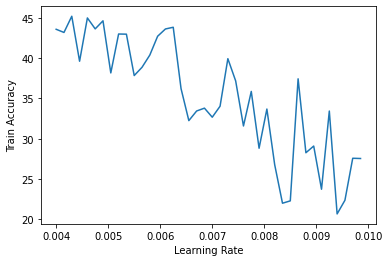

In [0]:
plt.plot(lrs,trainAcc)
plt.xlabel('Learning Rate')
plt.ylabel('Train Accuracy')

Text(0, 0.5, 'Test Accuracy')

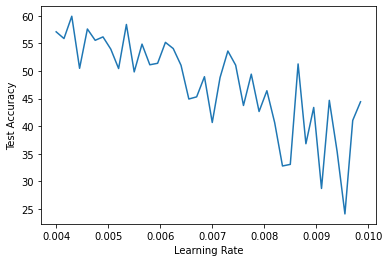

In [0]:
plt.plot(lrs,testAcc)
plt.xlabel('Learning Rate')
plt.ylabel('Test Accuracy')

In [0]:

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = dnn_architecture.New_Resnet().to(device)

EPOCHS = 24
lr = 0.015
max_lr = 0.015

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9,weight_decay=0.0005)
scheduler = OneCycleLR(optimizer, max_lr, total_steps=EPOCHS, epochs=None, steps_per_epoch=None,
                       pct_start=0.217, anneal_strategy='linear', cycle_momentum=False, base_momentum=0.85,
                       max_momentum=0.95, div_factor=8.0, final_div_factor=8.0, last_epoch=-1)

l_rate = []

train_test = train_and_test.Train_test()

for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1, 'LR:',optimizer.param_groups[0]['lr'])
    l_rate.append(optimizer.param_groups[0]['lr'])    
    train_acc,train_acc_epoch_end,train_losses,test_losses,test_acc = train_test.train_and_test(model, device, trainloader,testloader, optimizer, criterion, epoch)
    scheduler.step()
    if epoch == 5 and test_acc[-1]<70:
      break
    if epoch == 10 and test_acc[-1]<80:
      break
    if epoch == 15 and test_acc[-1]<85 :
      break


  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 1 LR: 0.001875


Loss=1.3865092992782593 Batch_id=97 Accuracy=42.37: 100%|██████████| 98/98 [01:39<00:00,  1.01s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0026, Accuracy: 5367/10000 (53.67%)

EPOCH: 2 LR: 0.0049940589353612164


Loss=1.1443740129470825 Batch_id=97 Accuracy=56.84: 100%|██████████| 98/98 [01:38<00:00,  1.01s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0020, Accuracy: 6470/10000 (64.70%)

EPOCH: 3 LR: 0.008113117870722433


Loss=0.8859703540802002 Batch_id=97 Accuracy=65.58: 100%|██████████| 98/98 [01:39<00:00,  1.01s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 6313/10000 (63.13%)

EPOCH: 4 LR: 0.01123217680608365


Loss=0.8876603245735168 Batch_id=97 Accuracy=69.07: 100%|██████████| 98/98 [01:38<00:00,  1.01s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0015, Accuracy: 7530/10000 (75.30%)

EPOCH: 5 LR: 0.014351235741444866


Loss=0.6984868049621582 Batch_id=97 Accuracy=74.01: 100%|██████████| 98/98 [01:38<00:00,  1.01s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0013, Accuracy: 7852/10000 (78.52%)

EPOCH: 6 LR: 0.014377693965517241


Loss=0.7453641891479492 Batch_id=97 Accuracy=78.50: 100%|██████████| 98/98 [01:38<00:00,  1.01s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 7746/10000 (77.46%)

EPOCH: 7 LR: 0.013591954022988505


Loss=0.5953543186187744 Batch_id=97 Accuracy=82.06: 100%|██████████| 98/98 [01:39<00:00,  1.01s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0011, Accuracy: 8129/10000 (81.29%)

EPOCH: 8 LR: 0.01280621408045977


Loss=0.6655864715576172 Batch_id=97 Accuracy=83.43: 100%|██████████| 98/98 [01:38<00:00,  1.01s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 7884/10000 (78.84%)

EPOCH: 9 LR: 0.012020474137931034


Loss=0.34536489844322205 Batch_id=97 Accuracy=85.07: 100%|██████████| 98/98 [01:38<00:00,  1.01s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0009, Accuracy: 8454/10000 (84.54%)

EPOCH: 10 LR: 0.011234734195402298


Loss=0.34832674264907837 Batch_id=97 Accuracy=87.39: 100%|██████████| 98/98 [01:39<00:00,  1.01s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0009, Accuracy: 8564/10000 (85.64%)

EPOCH: 11 LR: 0.010448994252873564


Loss=0.34085607528686523 Batch_id=97 Accuracy=88.70: 100%|██████████| 98/98 [01:39<00:00,  1.01s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 8701/10000 (87.01%)

EPOCH: 12 LR: 0.009663254310344828


Loss=0.24695734679698944 Batch_id=97 Accuracy=89.87: 100%|██████████| 98/98 [01:38<00:00,  1.01s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 8719/10000 (87.19%)

EPOCH: 13 LR: 0.008877514367816093


Loss=0.20718276500701904 Batch_id=97 Accuracy=90.92: 100%|██████████| 98/98 [01:38<00:00,  1.01s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 8766/10000 (87.66%)

EPOCH: 14 LR: 0.008091774425287357


Loss=0.21285408735275269 Batch_id=97 Accuracy=91.66: 100%|██████████| 98/98 [01:38<00:00,  1.01s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 8731/10000 (87.31%)

EPOCH: 15 LR: 0.007306034482758622


Loss=0.22716400027275085 Batch_id=97 Accuracy=92.54: 100%|██████████| 98/98 [01:38<00:00,  1.01s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 8739/10000 (87.39%)

EPOCH: 16 LR: 0.0065202945402298845


Loss=0.1922456920146942 Batch_id=97 Accuracy=93.22: 100%|██████████| 98/98 [01:38<00:00,  1.01s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 8920/10000 (89.20%)

EPOCH: 17 LR: 0.00573455459770115


Loss=0.13063184916973114 Batch_id=97 Accuracy=94.34: 100%|██████████| 98/98 [01:38<00:00,  1.01s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 8873/10000 (88.73%)

EPOCH: 18 LR: 0.004948814655172414


Loss=0.17827928066253662 Batch_id=97 Accuracy=94.81: 100%|██████████| 98/98 [01:38<00:00,  1.01s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 8970/10000 (89.70%)

EPOCH: 19 LR: 0.004163074712643679


Loss=0.1336013674736023 Batch_id=97 Accuracy=95.28: 100%|██████████| 98/98 [01:38<00:00,  1.01s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0006, Accuracy: 8994/10000 (89.94%)

EPOCH: 20 LR: 0.003377334770114945


Loss=0.09883862733840942 Batch_id=97 Accuracy=95.89: 100%|██████████| 98/98 [01:38<00:00,  1.01s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 8948/10000 (89.48%)

EPOCH: 21 LR: 0.0025915948275862088


Loss=0.09373544156551361 Batch_id=97 Accuracy=96.36: 100%|██████████| 98/98 [01:38<00:00,  1.01s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0006, Accuracy: 9037/10000 (90.37%)

EPOCH: 22 LR: 0.0018058548850574709


Loss=0.1132458746433258 Batch_id=97 Accuracy=96.80: 100%|██████████| 98/98 [01:39<00:00,  1.01s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0006, Accuracy: 9060/10000 (90.60%)

EPOCH: 23 LR: 0.0010201149425287364


Loss=0.07959786802530289 Batch_id=97 Accuracy=97.06: 100%|██████████| 98/98 [01:38<00:00,  1.01s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0006, Accuracy: 9063/10000 (90.63%)

EPOCH: 24 LR: 0.0002343750000000002


Loss=0.10198218375444412 Batch_id=97 Accuracy=97.31: 100%|██████████| 98/98 [01:39<00:00,  1.01s/it]



Test set: Average loss: 0.0006, Accuracy: 9072/10000 (90.72%)



In [0]:
print(l_rate)
l_rate.index(max(l_rate))

[0.001875, 0.0049940589353612164, 0.008113117870722433, 0.01123217680608365, 0.014351235741444866, 0.014377693965517241, 0.013591954022988505, 0.01280621408045977, 0.012020474137931034, 0.011234734195402298, 0.010448994252873564, 0.009663254310344828, 0.008877514367816093, 0.008091774425287357, 0.007306034482758622, 0.0065202945402298845, 0.00573455459770115, 0.004948814655172414, 0.004163074712643679, 0.003377334770114945, 0.0025915948275862088, 0.0018058548850574709, 0.0010201149425287364, 0.0002343750000000002]


5

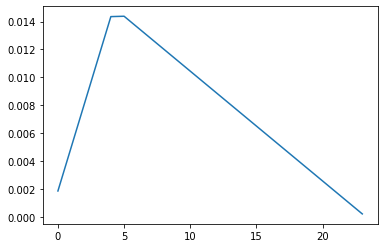

In [0]:
plt.plot(l_rate)

In [0]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

EPOCHS = 10
lr = l_rate[-1]

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9,weight_decay=0.0005)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=1, verbose=False, 
                              threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0.0001, eps=1e-08)


for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1, 'LR:',optimizer.param_groups[0]['lr'])  
    l_rate.append(optimizer.param_groups[0]['lr'])
    train_acc,train_acc_epoch_end,train_losses,test_losses,test_acc = train_test.train_and_test(model, device, trainloader,testloader, optimizer, criterion, epoch)
    scheduler.step(test_losses[-1])



  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 1 LR: 0.0002343750000000002


Loss=0.11473879218101501 Batch_id=97 Accuracy=97.34: 100%|██████████| 98/98 [01:39<00:00,  1.01s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0006, Accuracy: 9078/10000 (90.78%)

EPOCH: 2 LR: 0.0002343750000000002


Loss=0.07093360275030136 Batch_id=97 Accuracy=97.37: 100%|██████████| 98/98 [01:38<00:00,  1.01s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0006, Accuracy: 9074/10000 (90.74%)

EPOCH: 3 LR: 0.0002343750000000002


Loss=0.055240027606487274 Batch_id=97 Accuracy=97.27: 100%|██████████| 98/98 [01:38<00:00,  1.01s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0006, Accuracy: 9080/10000 (90.80%)

EPOCH: 4 LR: 0.0002343750000000002


Loss=0.12386738508939743 Batch_id=97 Accuracy=97.34: 100%|██████████| 98/98 [01:39<00:00,  1.01s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0006, Accuracy: 9075/10000 (90.75%)

EPOCH: 5 LR: 0.0002343750000000002


Loss=0.09480227530002594 Batch_id=97 Accuracy=97.32: 100%|██████████| 98/98 [01:38<00:00,  1.01s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0006, Accuracy: 9083/10000 (90.83%)

EPOCH: 6 LR: 0.0002343750000000002


Loss=0.11234153062105179 Batch_id=97 Accuracy=97.33: 100%|██████████| 98/98 [01:38<00:00,  1.01s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0006, Accuracy: 9075/10000 (90.75%)

EPOCH: 7 LR: 0.0002343750000000002


Loss=0.09054084867238998 Batch_id=97 Accuracy=97.42: 100%|██████████| 98/98 [01:38<00:00,  1.01s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0006, Accuracy: 9066/10000 (90.66%)

EPOCH: 8 LR: 0.0001


Loss=0.07853471487760544 Batch_id=97 Accuracy=97.46: 100%|██████████| 98/98 [01:39<00:00,  1.01s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0006, Accuracy: 9084/10000 (90.84%)

EPOCH: 9 LR: 0.0001


Loss=0.10054833441972733 Batch_id=97 Accuracy=97.52: 100%|██████████| 98/98 [01:39<00:00,  1.01s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0006, Accuracy: 9080/10000 (90.80%)

EPOCH: 10 LR: 0.0001


Loss=0.09024628251791 Batch_id=97 Accuracy=97.67: 100%|██████████| 98/98 [01:39<00:00,  1.01s/it]



Test set: Average loss: 0.0006, Accuracy: 9076/10000 (90.76%)



In [0]:
len(train_acc_epoch_end)

34

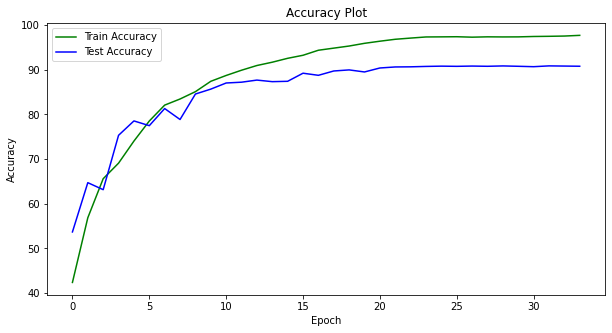

In [0]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
ax = plt.subplot(111)
ax.plot(train_acc_epoch_end,color = 'g',label="Train Accuracy")
ax.plot(test_acc,color = 'b',label="Test Accuracy")
ax.set(title="Accuracy Plot", xlabel="Epoch", ylabel="Accuracy")
ax.legend()
plt.show()

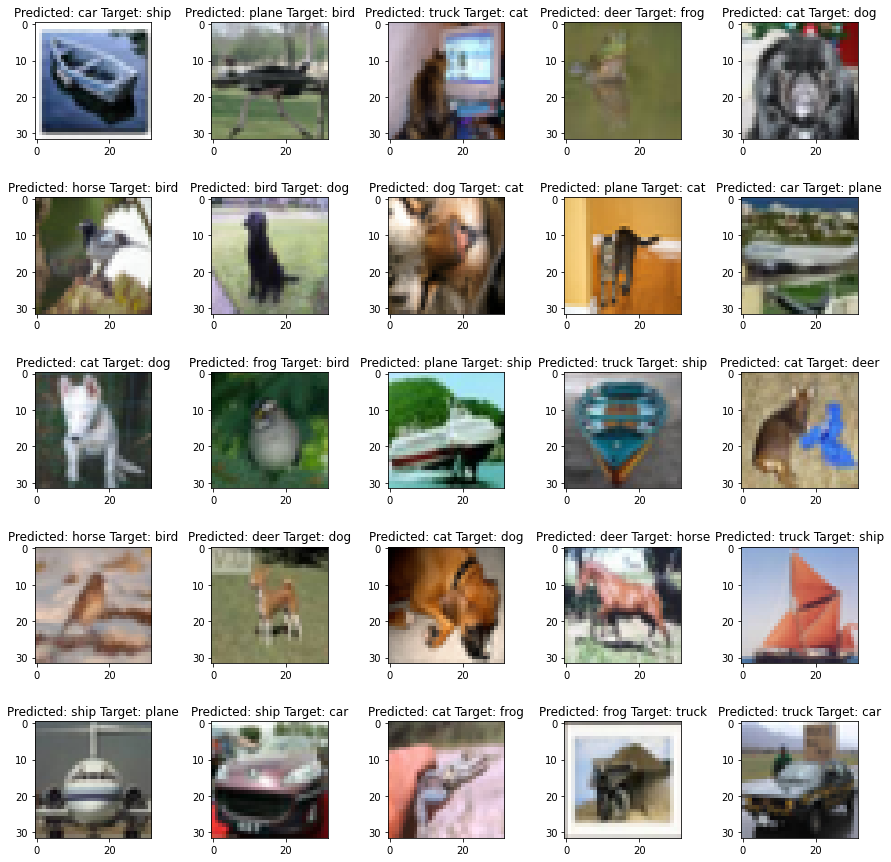

In [0]:
misclassify = show_images.show_misclassified_images(model, device, testloader,classes,num=25)

In [0]:
len(misclassify[1])

924

GroundTruth:   bird plane   dog  bird plane
Predicted:   bird  bird   dog  bird plane


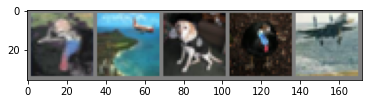

In [0]:
evaluate.show_predicted_actual(model, device, testloader, classes)

In [0]:
evaluate.evaluate_accuracy(model, device, testloader)

Accuracy of the network on the 10000 test images: 90 %


In [0]:
evaluate.evaluate_classwise_accuracy(model, device, classes, testloader)

Accuracy of plane : 66 %
Accuracy of   car : 100 %
Accuracy of  bird : 87 %
Accuracy of   cat : 100 %
Accuracy of  deer : 77 %
Accuracy of   dog : 80 %
Accuracy of  frog : 80 %
Accuracy of horse : 100 %
Accuracy of  ship : 85 %
Accuracy of truck : 100 %


In [0]:
model

New_Resnet(
  (prepLayer): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (cmbr_block1): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (res_block1): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (layer2): Sequential(
    (0): 

/content/gdrive/My Drive/Colab Notebooks/eva_files/gradcam.py:130: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  subplot_kw={'xticks': [], 'yticks': []})


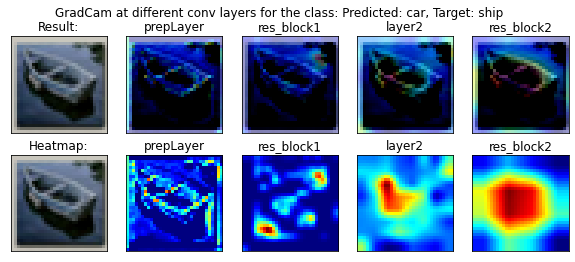

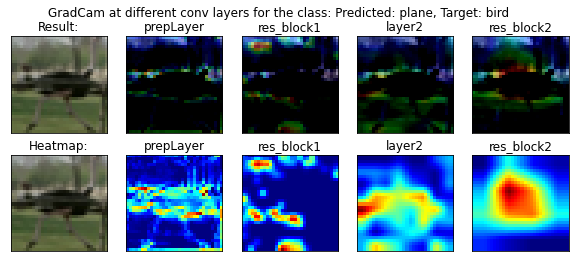

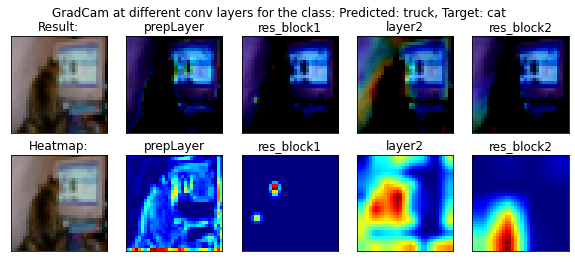

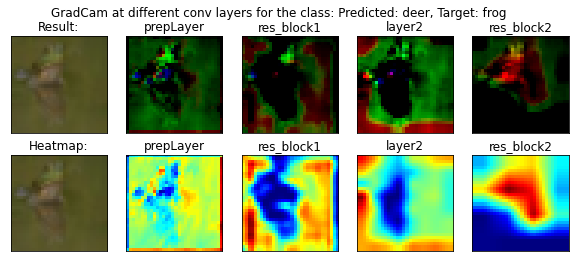

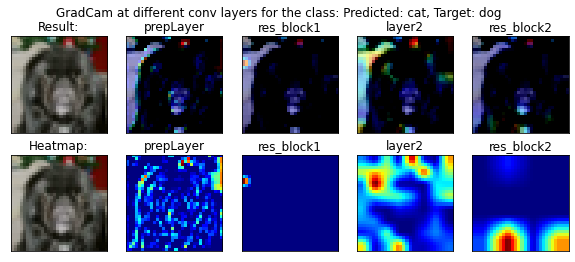

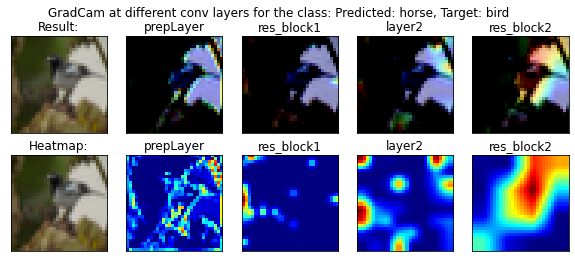

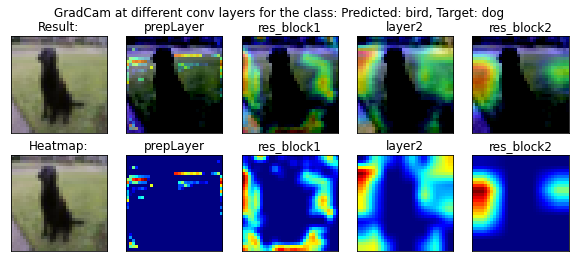

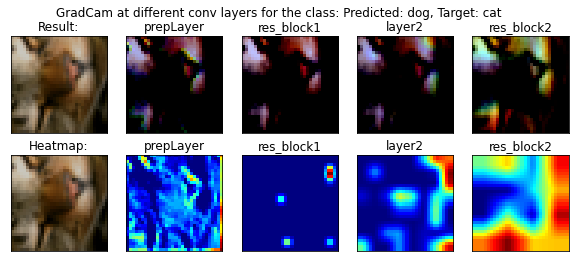

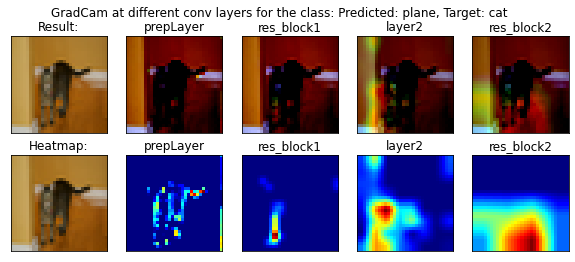

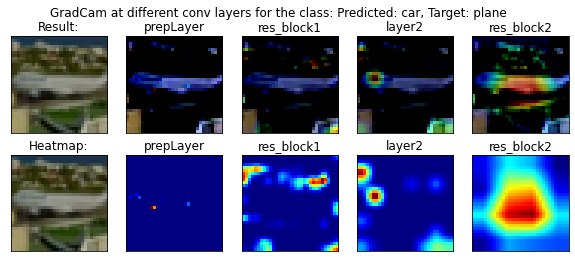

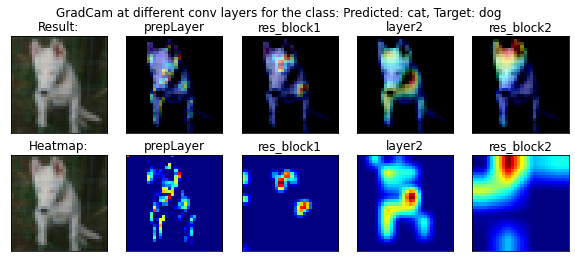

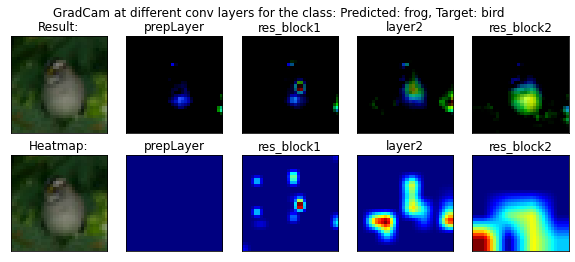

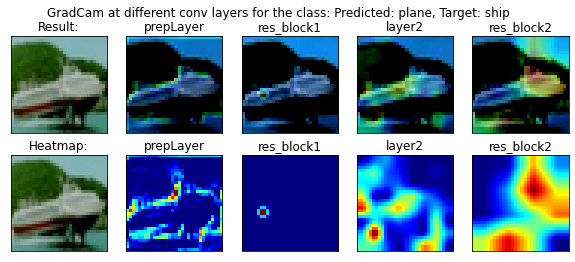

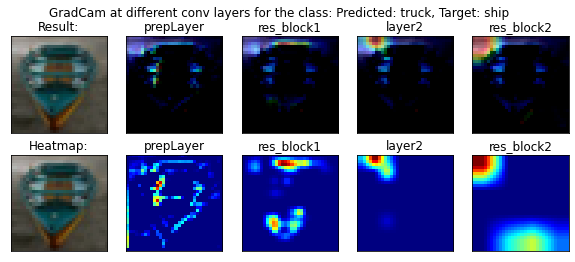

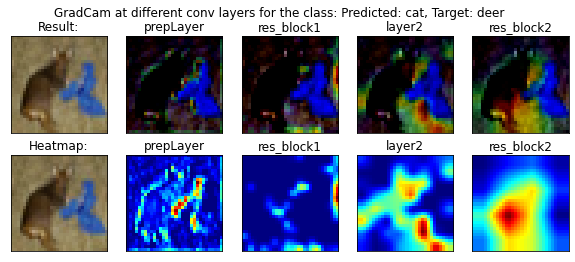

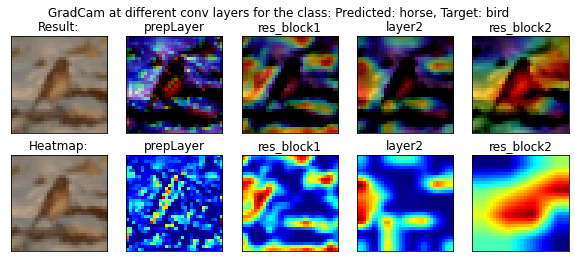

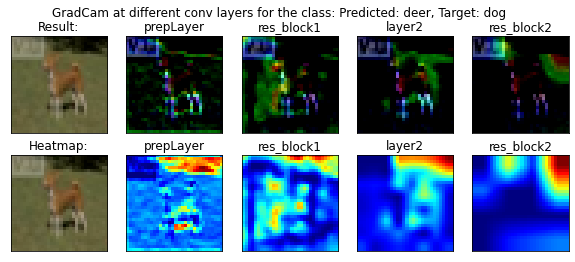

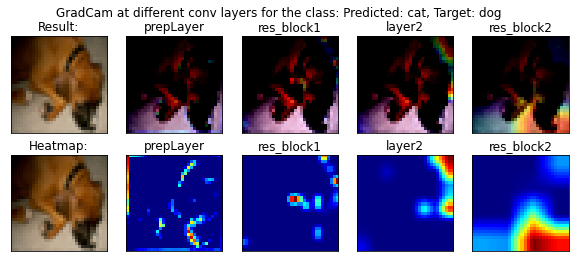

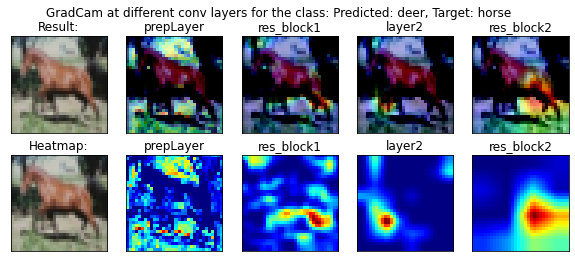

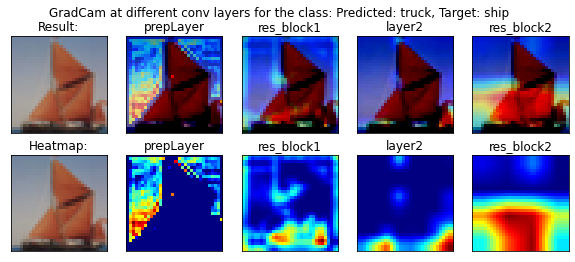

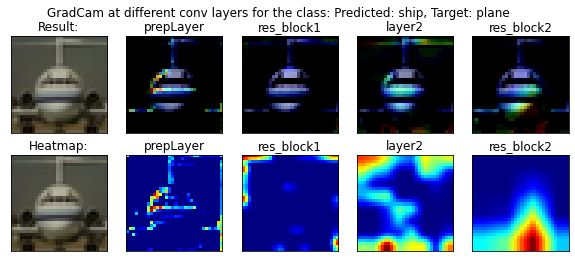

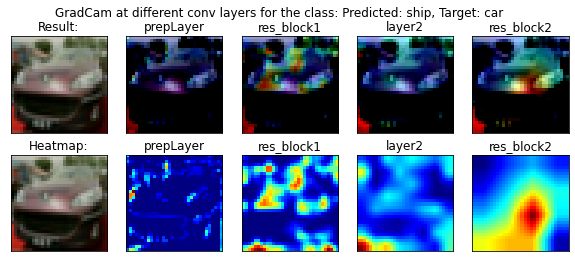

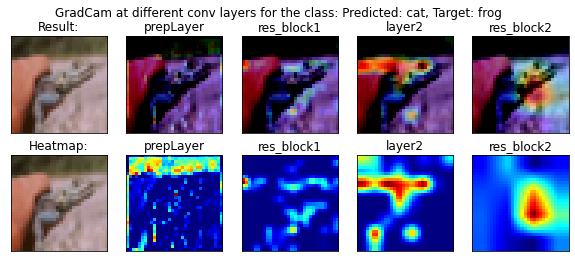

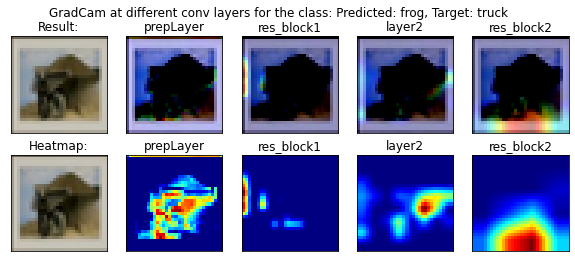

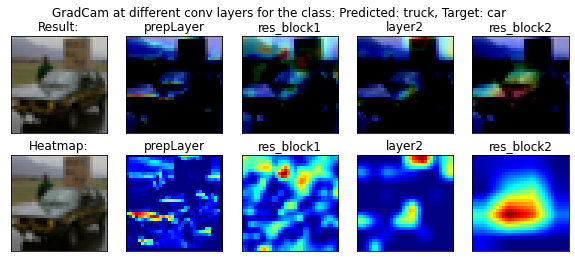

In [0]:
images=[]

for i in range(25):
  images.append(misclassify[0][i]*2-0.5)

target_layers = ["prepLayer","res_block1","layer2","res_block2"]
gradcam = gradcam.VisualizeCam(model,classes, target_layers)
gradcam(torch.stack(images), target_layers,target_class=misclassify[2],pred=misclassify[1],num=25,name='misclassify')